In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

plt.style.use('../../figure_style.mplstyle')

print(torch.cuda.is_available())

True


In [3]:
from matplotlib import collections
import matplotlib as mpl
def plot_mesh(data, mesh, ax,
              cmap=plt.cm.viridis,
              vmin=None, vmax=None,
              colorbar=True,
              colorbar_title=""):

    # Dolfin mesh, stores values on vertices not faces
    coords = mesh.coordinates().T
    cells = mesh.cells().T
    values = data[cells].mean(axis=0)

    xmin, ymin = coords.min(axis=1)
    xmax, ymax = coords.max(axis=1)

    polygons = coords[:, cells]
    polygons = np.moveaxis(polygons, (0, 1, 2), (2, 1, 0))
    col = collections.PolyCollection(polygons)
    
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    col.set_color(cmap(norm(values)))
    ax.add_collection(col)
    ax.set(xlim=[xmin, xmax],
           ylim=[ymin, ymax])
    ax.set_aspect(1)

    if colorbar:
        sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        vmin, vmax = sm.get_clim()
        vmean = (vmin + vmax)/2
        cax = ax.inset_axes([1.05, 0, 0.05, 1])
        cbar = plt.colorbar(sm, cax=cax, ax=ax,
                            ticks=[vmin, vmean, vmax])
        cbar.ax.set_ylabel(colorbar_title, rotation=-90)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def plot_with_regression(ax, x, y, color='black', label=''):
    score = r2_score(x, y)
    label = ' '.join([label, f'$R^2$ = {score:.2f}'])
    ax.scatter(x, y, color=color, label=label, s=5)

    model = LinearRegression().fit(x[:,None], y[:,None])
    score = model.score(x[:, None], y[:, None])
    eqn = f'y = {model.coef_[0,0]:.2f} x + {np.squeeze(model.intercept_):.2f}'

    xr = np.array([np.min(x), np.max(x)])[:, None]
    yr = model.predict(xr)
    ax.plot(xr, yr, color=color, label=eqn)


# Solving forward and reverse problems with `dolfin` and `dolfin-adjoint`

Here we are solving the two-dimensional Poisson equation as a forward problem 

$$ \nabla^2 u(x, y) = f(x, y) $$

[d3-w4140b-07:63273] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.d3-w4140b-07.614072/jf.0/1945567232/shared_mem_cuda_pool.d3-w4140b-07 could be created.
[d3-w4140b-07:63273] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


------------------------
Exact-Dolfin MSE: 5.89e-05


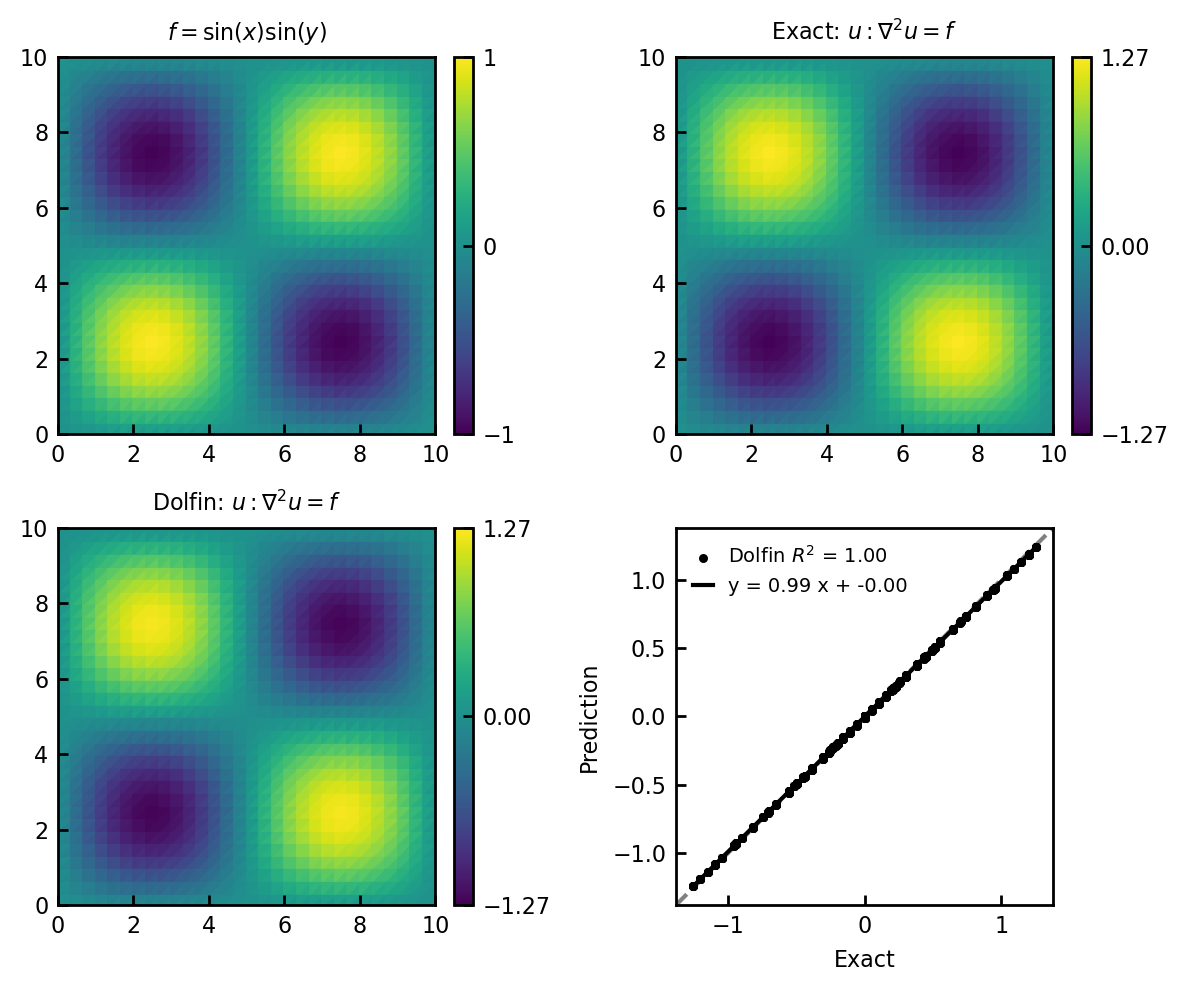

In [4]:
import ufl
import dolfin as dlf
import dolfin_adjoint as d_ad
import pyadjoint as pyad

# Turn off annoying log messages
import logging
logging.getLogger('FFC').setLevel(logging.ERROR)
dlf.set_log_level(40)

# Create mesh and function space
mesh = d_ad.RectangleMesh(
    dlf.Point(0., 0.), dlf.Point(10., 10.), nx=30, ny=30
)
element = ufl.FiniteElement('CG', mesh.ufl_cell(), 1)
function_space = dlf.FunctionSpace(mesh, element)

# Create the forcing function
xmin, ymin = np.min(mesh.coordinates(), axis=0)
xptp, yptp = np.ptp(mesh.coordinates(), axis=0)
xscl, yscl = xptp / (2 * np.pi), yptp / (2 * np.pi)

f = d_ad.Function(function_space)
f_expr = d_ad.Expression(
    "sin((x[0]-xmin)/xscl) * sin((x[1]-ymin)/yscl)",
    xmin=xmin, ymin=ymin, xscl=xscl, yscl=yscl, degree=2
)
f.interpolate(f_expr)

# Create the boundary condition
bc = d_ad.DirichletBC(function_space, d_ad.Constant(0.), 'on_boundary')

# Compute the exact solution
u_exact = d_ad.Function(function_space)
u_expr = d_ad.Expression(
    "-(pow(xscl, 2) * pow(yscl, 2)) / (pow(xscl, 2) + pow(yscl, 2)) * sin((x[0]-xmin)/xscl) * sin((x[1]-ymin)/yscl)",
    xmin=xmin, ymin=ymin, xscl=xscl, yscl=yscl, degree=2
)
u_exact.interpolate(u_expr)
exact = u_exact.compute_vertex_values()

# Solve the forward problem using Dolfin
u = dlf.TrialFunction(function_space)
v = dlf.TestFunction(function_space)

a = -ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx

u_dolfin = d_ad.Function(function_space)
d_ad.solve(a == L, u_dolfin, bc)
dlf_sol = u_dolfin.compute_vertex_values()

# Plot and compare
fig, ax = plt.subplots(2, 2, figsize=(6,5))
ax = ax.flatten()
vmax = np.round((xscl**2 * yscl**2) / (xscl**2 + yscl**2), decimals=2)
vmin=-vmax

# Forcing function
plot_mesh(f.compute_vertex_values(), mesh, ax[0], vmin=-1, vmax=1)
ax[0].set_title(r'$f = \sin(x) \sin(y)$')

# Exact solution
plot_mesh(exact, mesh, ax[1], vmin=vmin, vmax=vmax)
ax[1].set_title(r'Exact: $u: \nabla^2 u = f$')

# Dolfin solution
plot_mesh(dlf_sol, mesh, ax[2], vmin=vmin, vmax=vmax)
ax[2].set_title(r'Dolfin: $u: \nabla^2 u = f$')

plot_with_regression(ax[3], exact, dlf_sol, label='Dolfin', color='black')
ax[3].set(xlabel='Exact', ylabel='Prediction')
xlim, ylim = ax[3].get_xlim(), ax[3].get_ylim()
ax[3].plot(xlim, xlim, color='grey', linestyle='--', zorder=-1)
ax[3].set(xlim=xlim, ylim=xlim, aspect='equal')
ax[3].legend()

plt.tight_layout()

print('------------------------')
print(f'Exact-Dolfin MSE: {np.mean(np.power(exact - dlf_sol, 2)):.3g}')

For PDE-constrained optimization, we may want to solve the inverse problem of determining $f$ to produce a given $u$. To achieve, this, we need to first define a loss function

$$ \mathcal{L} = \int_{\Omega} \big(u_{dlf}[f(x, y)] - u_{exact}\big)^2 \, dA $$

Next, we need to minimize this loss by computing its derivative with respect to the input $f(x, y)$. We can do this using the adjoint method or by backpropagation via `dolfin-adjoint`. 

dolfin-adjoint produces a loss of 0.00618 and grad of size (961,)


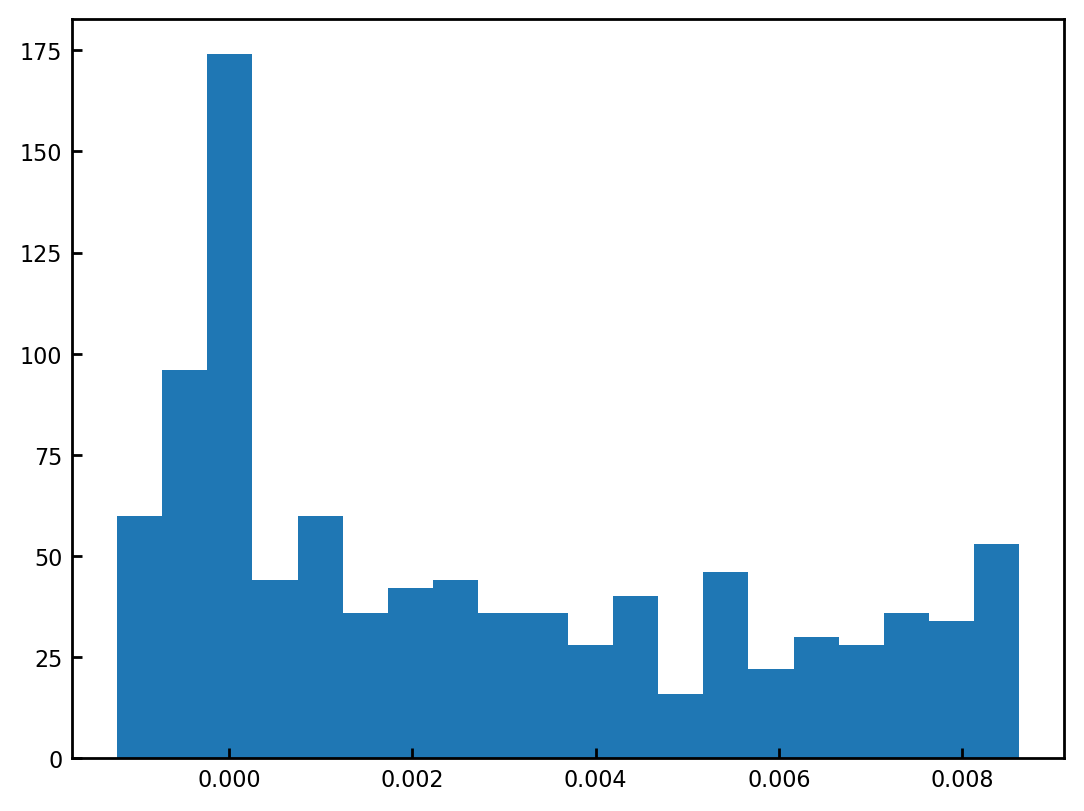

In [7]:
# The dolfin solution is stored in u_dolfin
loss = ufl.inner(u_dolfin - u_exact, u_dolfin - u_exact) * ufl.dx
J = d_ad.assemble(loss)

# Define a control variable that we can tune
control = d_ad.Control(f)

# A reduced functional maps a control value (f) to the provided funtctional (loss)
# This allows us to compute the derivative of the loss w.r.t. f
Jhat = pyad.reduced_functional_numpy.ReducedFunctionalNumPy(J, control)
# We use the Numpy version because it allows us to use an array of scalars as control 
# This will eventually interface better with PyTorch
dolfin_loss = Jhat(f.vector()[:])
dolfin_grad = Jhat.derivative()

print(f'dolfin-adjoint produces a loss of {dolfin_loss:.3g} and grad of size {dolfin_grad.shape}')
plt.hist(dolfin_grad, bins=20);

# Exporting the problem to `scipy.sparse`

Working explicitly with pyadjoint is a bit annoying when we want to throw `torch` into the mix. To get around this for some problems, we can export the assembled problem and solve it using the `scipy.sparse` linear algebra functionality.

We start by noting that Dolfin aims to find the solution $u$ such that

$$ -\int_{\Omega} \nabla u \cdot \nabla v \, dx = \int_{\Omega} f \cdot v \, dx \quad  \forall v \in V $$

Under the hood, Doflin solves this by converting it to a linear algebra problem. More details on this process will come later. For now, it suffices to assume that this is reduced to the form 

$$ A u = L $$

The ordinary least squares solution to this problem is 

$$ u = (A^T A)^{-1} A^T L $$

In reality, $f$ is a vector of function values at discrete points and $L$ is an assembled vector. To get $L$, we also need to assemble the problem $ \int_{\Omega} u \cdot v \, dx = \int_{\Omega} f \cdot v\, dx $ into a linear problem

------------------------
Exact-Matrix MSE: 5.04e-06


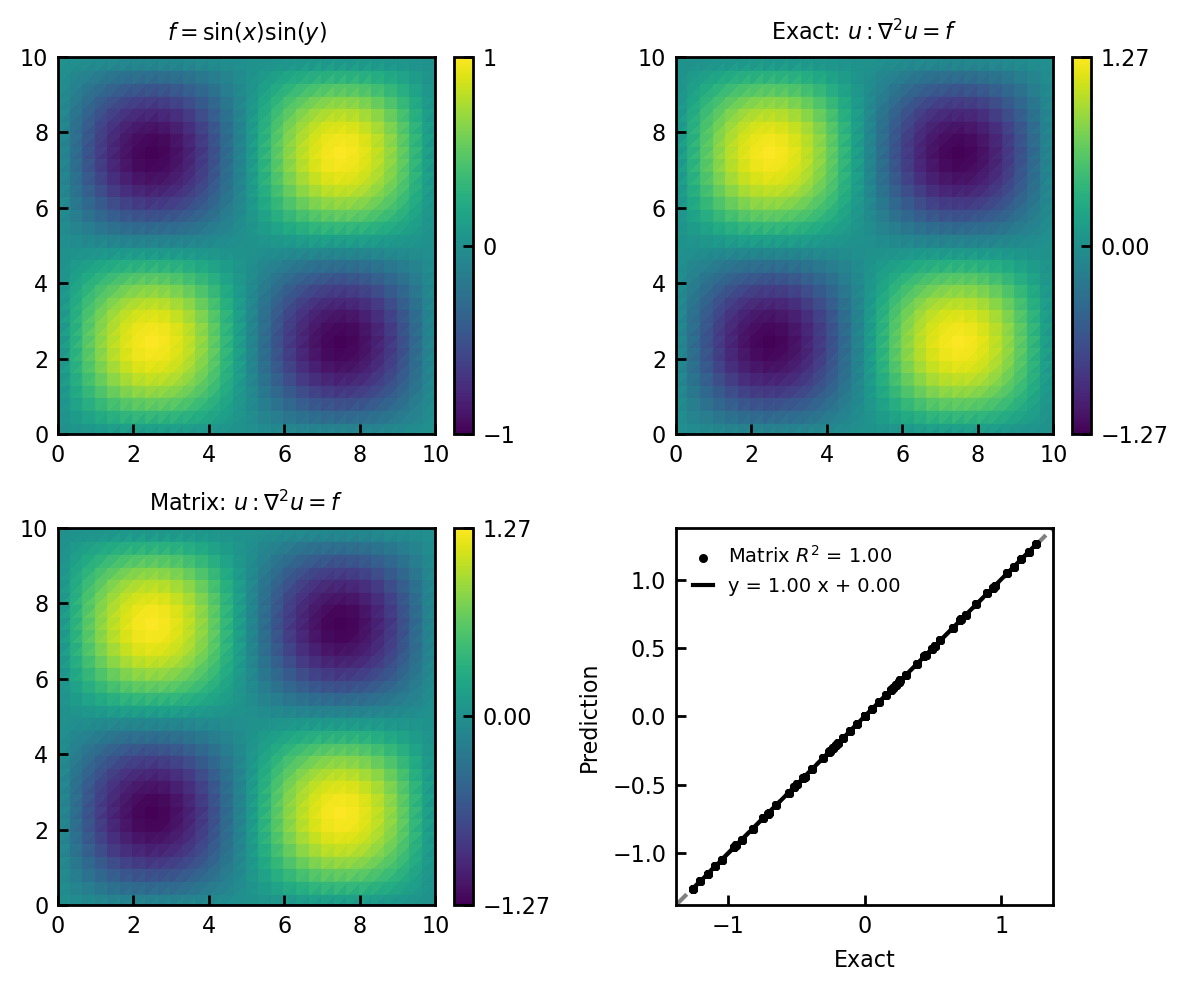

In [7]:
import scipy
from scipy import sparse

d2v = dlf.dof_to_vertex_map(function_space)
v2d = dlf.vertex_to_dof_map(function_space)

# Assemble the problem again
a = - ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx #RHS
A = dlf.assemble(a)
bc.apply(A)

# Convert to scipy sparse matrix
A = sparse.csr_matrix(A.array())

# Solve the linear algebra problem
mat_sol = sparse.linalg.inv(A.T @ A) @ A.T @ f.vector()[:]

# Account for internal scaling
diag = dlf.assemble(v * ufl.dx)[:]
mat_sol = mat_sol * diag

# Undo dof mapping
mat_sol = mat_sol[v2d]

# Plot and compare
fig, ax = plt.subplots(2, 2, figsize=(6,5))
ax = ax.flatten()
vmax = np.round((xscl**2 * yscl**2) / (xscl**2 + yscl**2), decimals=2)
vmin=-vmax

# Forcing function
plot_mesh(f.compute_vertex_values(), mesh, ax[0], vmin=-1, vmax=1)
ax[0].set_title(r'$f = \sin(x) \sin(y)$')

# Exact solution
plot_mesh(exact, mesh, ax[1], vmin=vmin, vmax=vmax)
ax[1].set_title(r'Exact: $u: \nabla^2 u = f$')

# Dolfin solution
plot_mesh(mat_sol, mesh, ax[2], vmin=vmin, vmax=vmax)
ax[2].set_title(r'Matrix: $u: \nabla^2 u = f$')

plot_with_regression(ax[3], exact, mat_sol, label='Matrix', color='black')
ax[3].set(xlabel='Exact', ylabel='Prediction')
xlim, ylim = ax[3].get_xlim(), ax[3].get_ylim()
ax[3].plot(xlim, xlim, color='grey', linestyle='--', zorder=-1)
ax[3].set(xlim=xlim, ylim=xlim, aspect='equal')
ax[3].legend()

plt.tight_layout()

print('------------------------')
print(f'Exact-Matrix MSE: {np.mean(np.power(exact - mat_sol, 2)):.3g}')


To handle the reverse problem, we can backpropagate using `torch`. This does not quite work yet but I'm trying to figure it out

5.8869948525859915e-05 5.040318e-06 9.384408444913802e-05
matrix-solution produces a loss of 0.00484 and grad of size (961,)


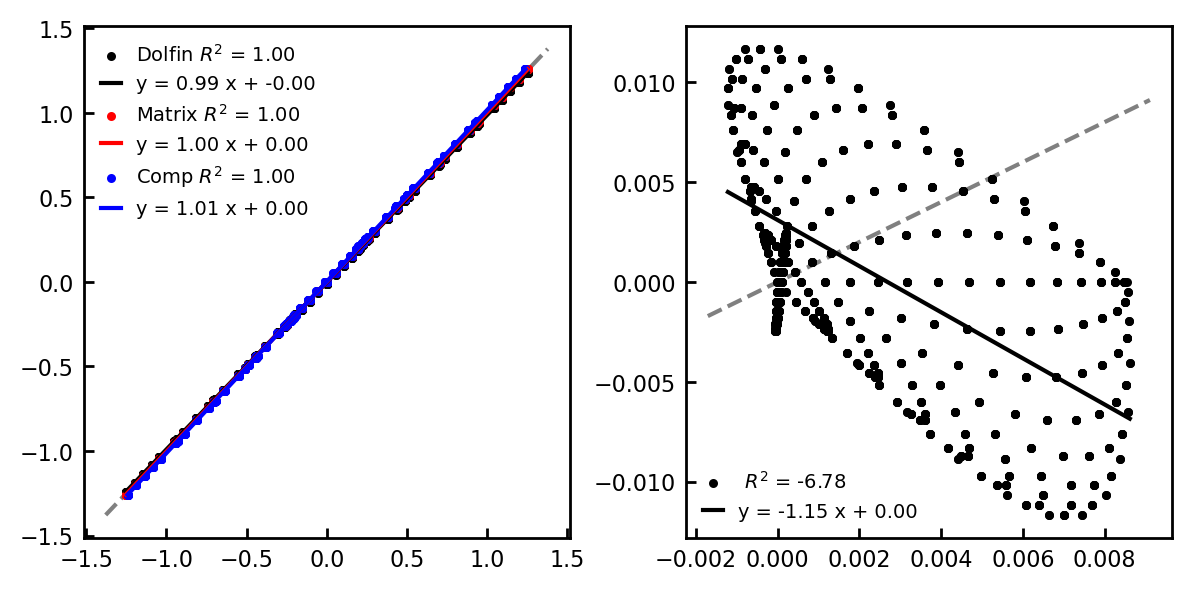

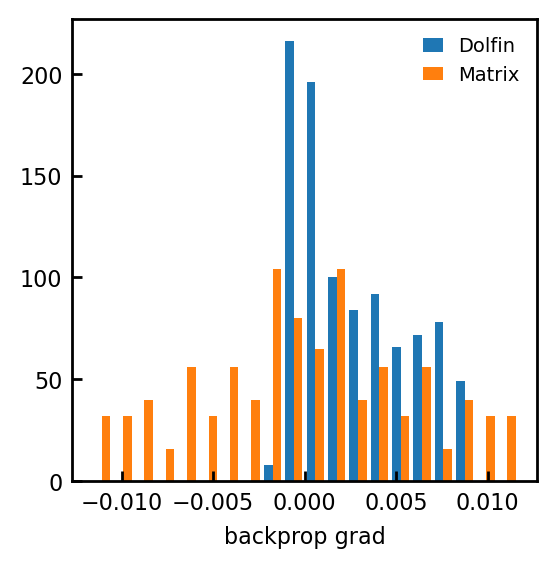

In [13]:
# Assemble the forward problem
a = - ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx #RHS
A = dlf.assemble(a)
bc.apply(A)

# Account for internal scaling
diag = dlf.assemble(v * ufl.dx)[:]

# Convert relevant variables to torch
A = sparse.csr_matrix(A.array())
rhs = sparse.linalg.inv(A.T @ A) @ A.T
rhs = torch.FloatTensor(rhs.todense())
diag = torch.FloatTensor(diag)

f_torch = torch.FloatTensor(f.vector()[:])
f_torch = torch.nn.Parameter(f_torch, requires_grad=True)

u_exact_torch = torch.FloatTensor(u_exact.vector()[:])

# Solve the forward linear algebra problem
mat_sol = rhs @ f_torch * diag

# Compute the loss and backprop
diff = mat_sol - u_exact_torch
matrix_loss = torch.sum( torch.pow( diff, 2) )
matrix_loss.backward()
matrix_grad = f_torch.grad.numpy()

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

print(
    mse(u_dolfin.vector()[:], u_exact_torch.numpy()),
    mse(mat_sol.detach().numpy(), u_exact_torch.numpy()),
    mse(u_dolfin.vector()[:], mat_sol.detach().numpy())
)

print(f'matrix-solution produces a loss of {matrix_loss.item():.3g} and grad of size {matrix_grad.shape}')


fig, ax = plt.subplots(1, 2, figsize=(6,3))

plot_with_regression(ax[0], u_exact_torch.numpy(), u_dolfin.vector()[:], label='Dolfin', color='black')
plot_with_regression(ax[0], u_exact_torch.numpy(), mat_sol.detach(), label='Matrix', color='red')
plot_with_regression(ax[0], u_dolfin.vector()[:], mat_sol.detach(), label='Comp', color='blue')

plot_with_regression(ax[1], dolfin_grad, matrix_grad)

for a in ax:
    a.legend()
    xlim, ylim = a.get_xlim(), a.get_ylim()
    a.plot(xlim, xlim, color='grey', linestyle='--', zorder=-1)
    #a.set(xlim=xlim, ylim=xlim, aspect='equal')

plt.tight_layout()

ax = plt.figure(figsize=(3,3)).gca()
ax.hist([dolfin_grad, matrix_grad], bins=20, label=['Dolfin', 'Matrix']);
ax.set_xlabel('backprop grad')
ax.legend()

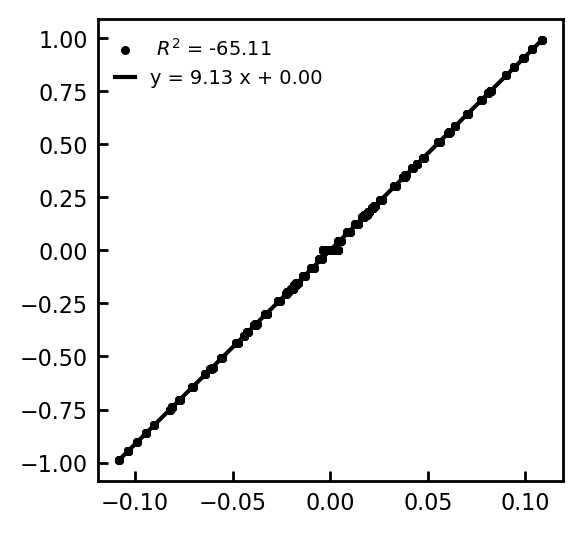

In [110]:
ax = plt.figure(figsize=(3,3)).gca()
plot_with_regression(ax, dlf.assemble(L)[:], f.vector()[:])
ax.legend()